# **ЗНАЧЕНИЕ ТЕРМИНОВ, ИСПОЛЬЗУЕМЫХ В НАБОРЕ ДАННЫХ**

- **GDP per capita:** ВВП на душу населения - это показатель экономического производства страны, который отражает численность ее населения.
Социальная поддержка: Социальная поддержка означает наличие друзей и других людей, включая семью, к которым можно обратиться в трудную минуту или в кризис, чтобы расширить кругозор и создать позитивную самооценку. Социальная поддержка повышает качество жизни и обеспечивает защиту от неблагоприятных жизненных событий.

- **Social support:** Ожидаемая продолжительность здоровой жизни — это среднее количество лет, в течение которых новорожденный может рассчитывать прожить в "полном здравии", другими словами, без инвалидизирующих заболеваний или травм.

- **Healthy life expectancy:** Свобода выбора описывает возможность и автономию индивида совершить действие, выбранное по крайней мере из двух доступных вариантов, без ограничений со стороны внешних сторон.

- **Generosity:** качество быть добрым и великодушным.

- **Perceptions of corruption:** Индекс восприятия коррупции (ИПЦ) - это индекс, ежегодно публикуемый Transparency International с 1995 года, который ранжирует страны "по их предполагаемому уровню коррупции в государственном секторе, определяемому экспертными оценками и опросами общественного мнения.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import scipy.cluster.hierarchy as shc
import plotly.graph_objs as go
from plotly.offline import iplot
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

from google.colab import drive
drive.mount('/content/drive')
folder = '/content/drive/My Drive/Git/'
filename = '2019.csv'

df = os.path.join(folder, filename)
df = pd.read_csv(df)

Mounted at /content/drive


In [2]:
df

,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,1,Finland,7.769,1.340,1.587,0.986,0.596,0.153,0.393
1,2,Denmark,7.600,1.383,1.573,0.996,0.592,0.252,0.410
2,3,Norway,7.554,1.488,1.582,1.028,0.603,0.271,0.341
3,4,Iceland,7.494,1.380,1.624,1.026,0.591,0.354,0.118
4,5,Netherlands,7.488,1.396,1.522,0.999,0.557,0.322,0.298
...,...,...,...,...,...,...,...,...,...
151,152,Rwanda,3.334,0.359,0.711,0.614,0.555,0.217,0.411
152,153,Tanzania,3.231,0.476,0.885,0.499,0.417,0.276,0.147
153,154,Afghanistan,3.203,0.350,0.517,0.361,0.000,0.158,0.025
154,155,Central African Republic,3.083,0.026,0.000,0.105,0.225,0.235,0.035


Выделение максимального значения каждого атрибута в наборе данных

In [5]:
original = df.copy()
def highlight_max(s):
  is_max = s == s.max()
  return ['background-color: limegreen' if v else '' for v in is_max]

df.style.apply(highlight_max, subset=['Score', 'GDP per capita', 'Social support',
                                      'Healthy life expectancy', 'Freedom to make life choices',
                                      'Generosity', 'Perceptions of corruption'])

,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,1,Finland,7.769000,1.340000,1.587000,0.986000,0.596000,0.153000,0.393000
1,2,Denmark,7.600000,1.383000,1.573000,0.996000,0.592000,0.252000,0.410000
2,3,Norway,7.554000,1.488000,1.582000,1.028000,0.603000,0.271000,0.341000
3,4,Iceland,7.494000,1.380000,1.624000,1.026000,0.591000,0.354000,0.118000
4,5,Netherlands,7.488000,1.396000,1.522000,0.999000,0.557000,0.322000,0.298000
5,6,Switzerland,7.480000,1.452000,1.526000,1.052000,0.572000,0.263000,0.343000
6,7,Sweden,7.343000,1.387000,1.487000,1.009000,0.574000,0.267000,0.373000
7,8,New Zealand,7.307000,1.303000,1.557000,1.026000,0.585000,0.330000,0.380000
8,9,Canada,7.278000,1.365000,1.505000,1.039000,0.584000,0.285000,0.308000
9,10,Austria,7.246000,1.376000,1.475000,1.016000,0.532000,0.244000,0.226000


Проверяем форму нашего набора данных



In [6]:
df.shape

(156, 9)

Определение атрибутов, которые сильно коррелируют друг с другом, с помощью тепловой карты

<ipython-input-7-1f7d74544dde>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = df.corr()


<Axes: >

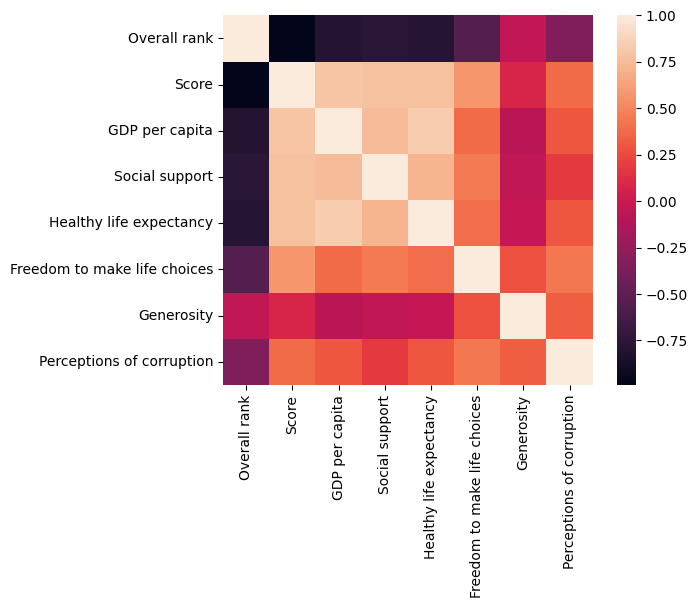

In [7]:
corrmat = df.corr()
f, ax = plt.subplots()
sns.heatmap(corrmat, square=True)

Построение парных соотношений в наборе данных.

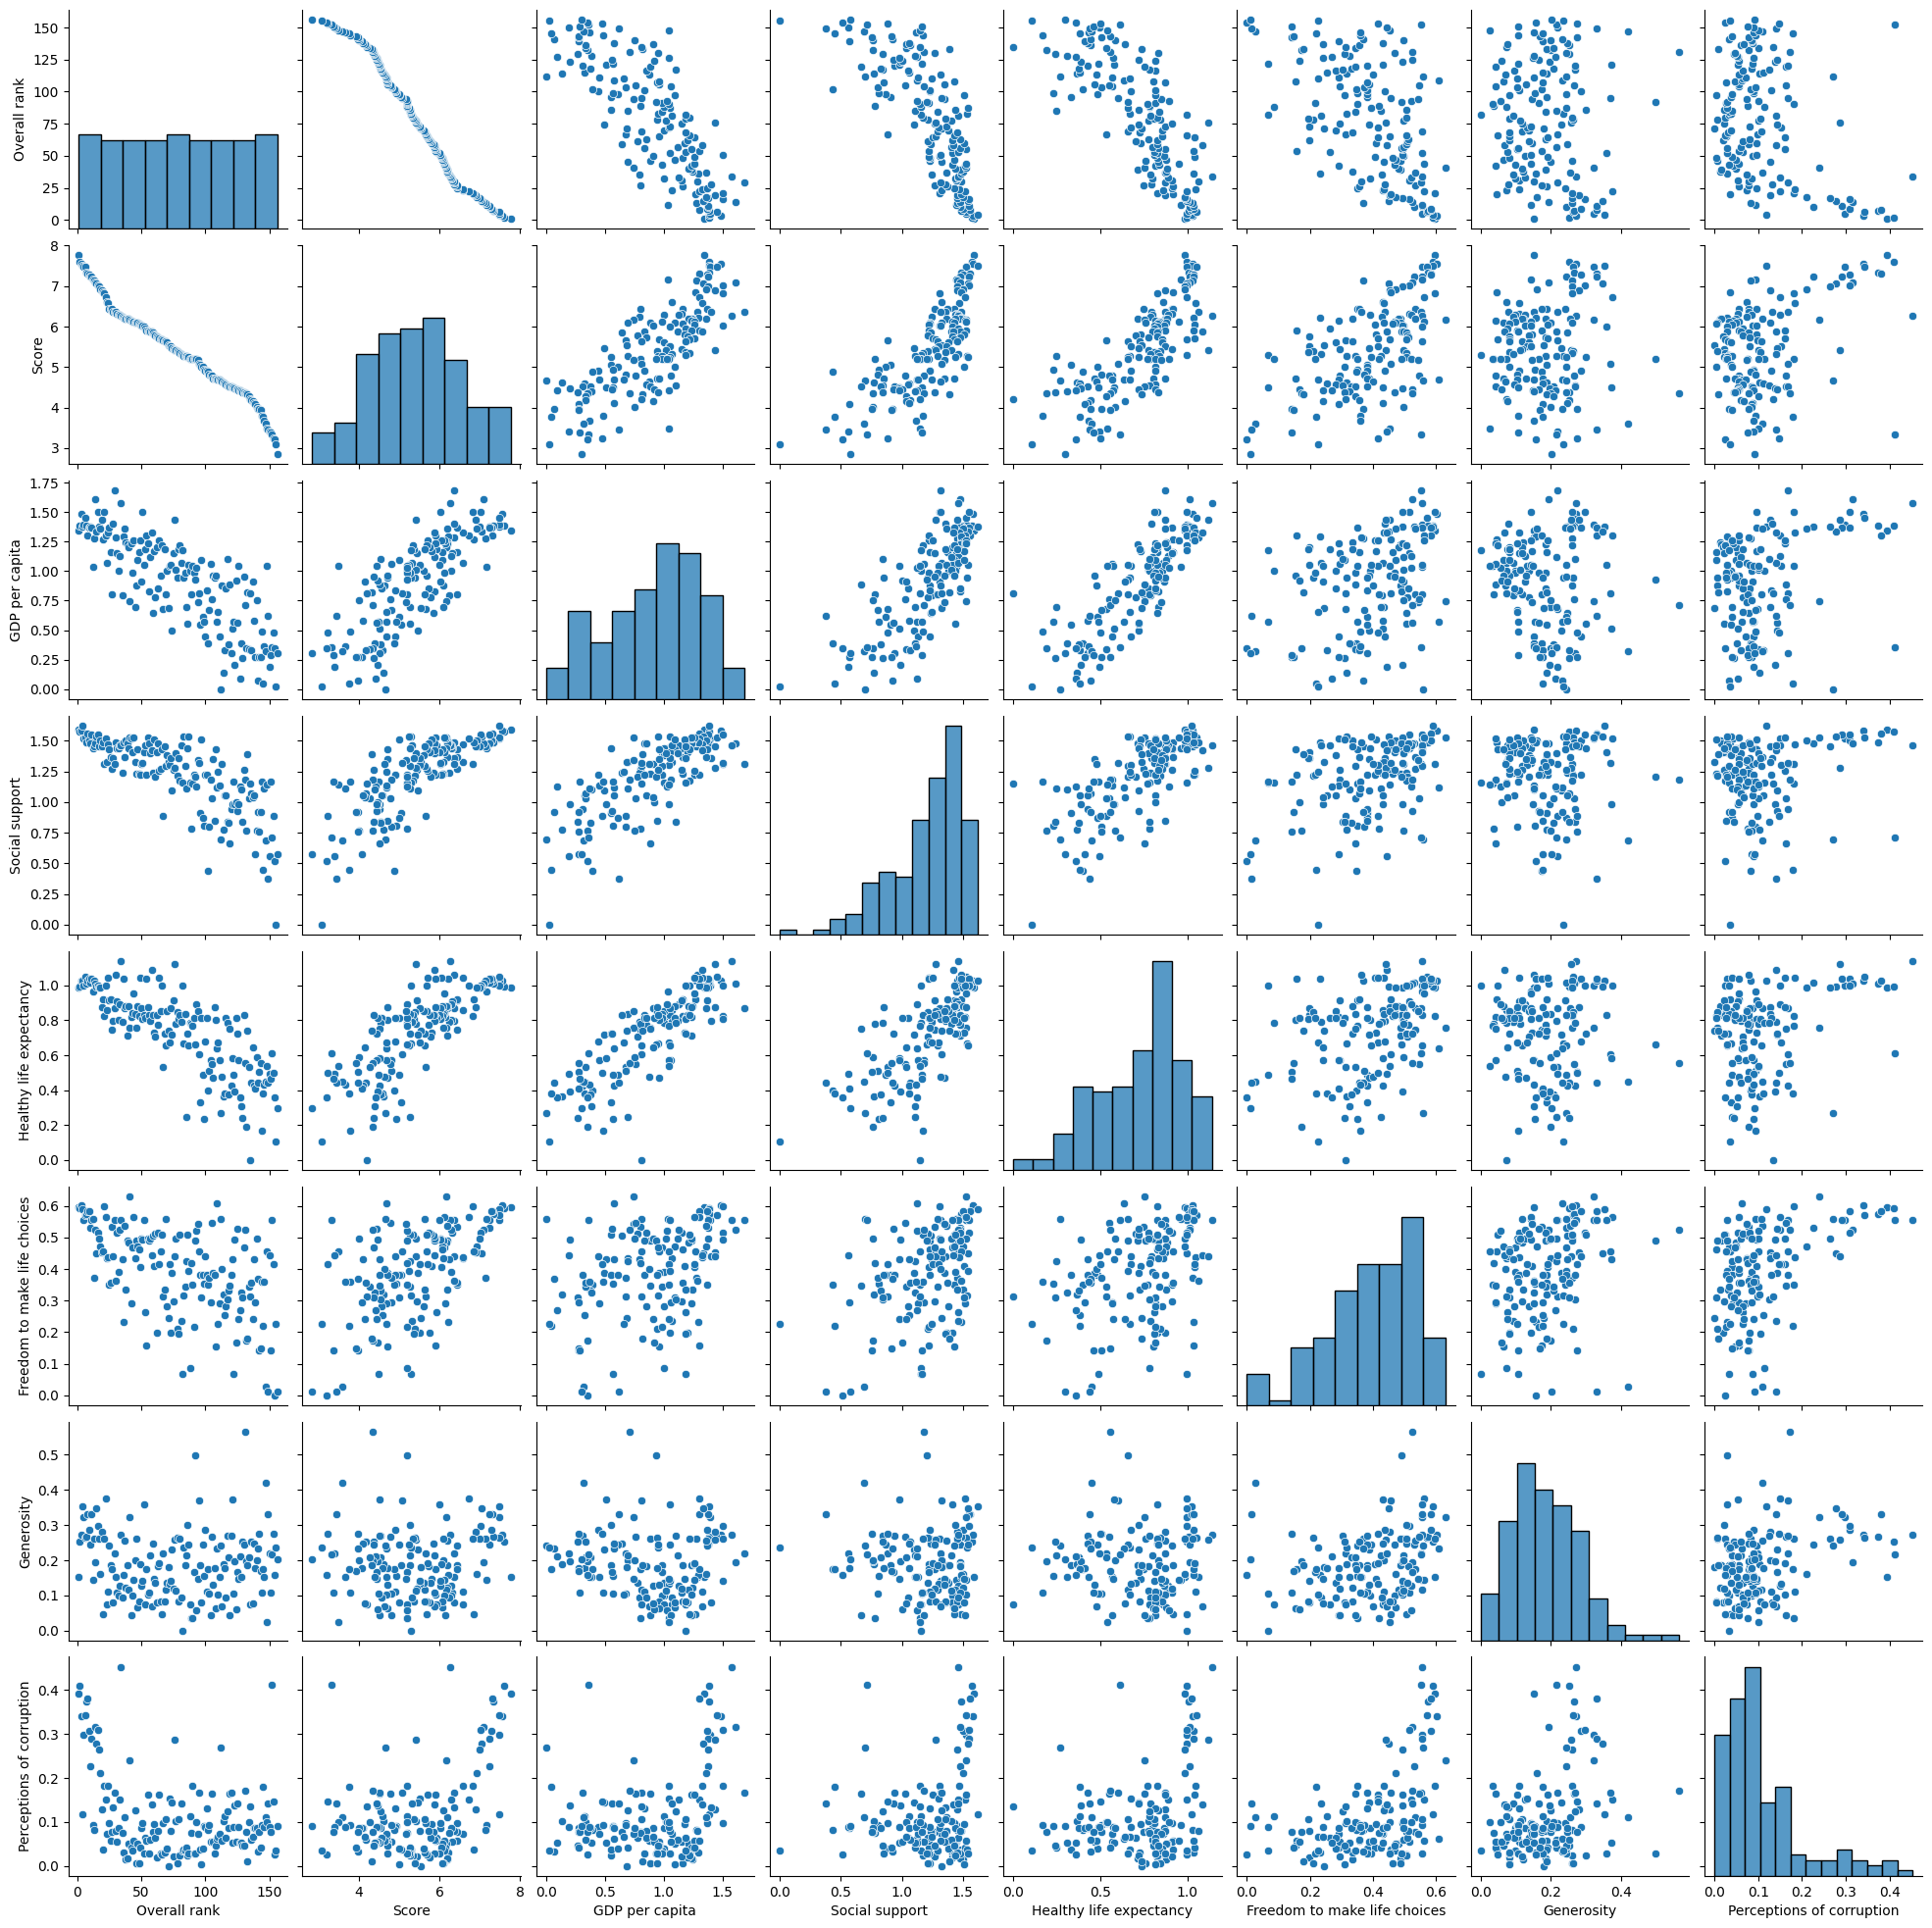

In [8]:
sns.pairplot(df)

Топ-10 стран по каждому признаку.

<Axes: xlabel='Perceptions of corruption', ylabel='Country or region'>

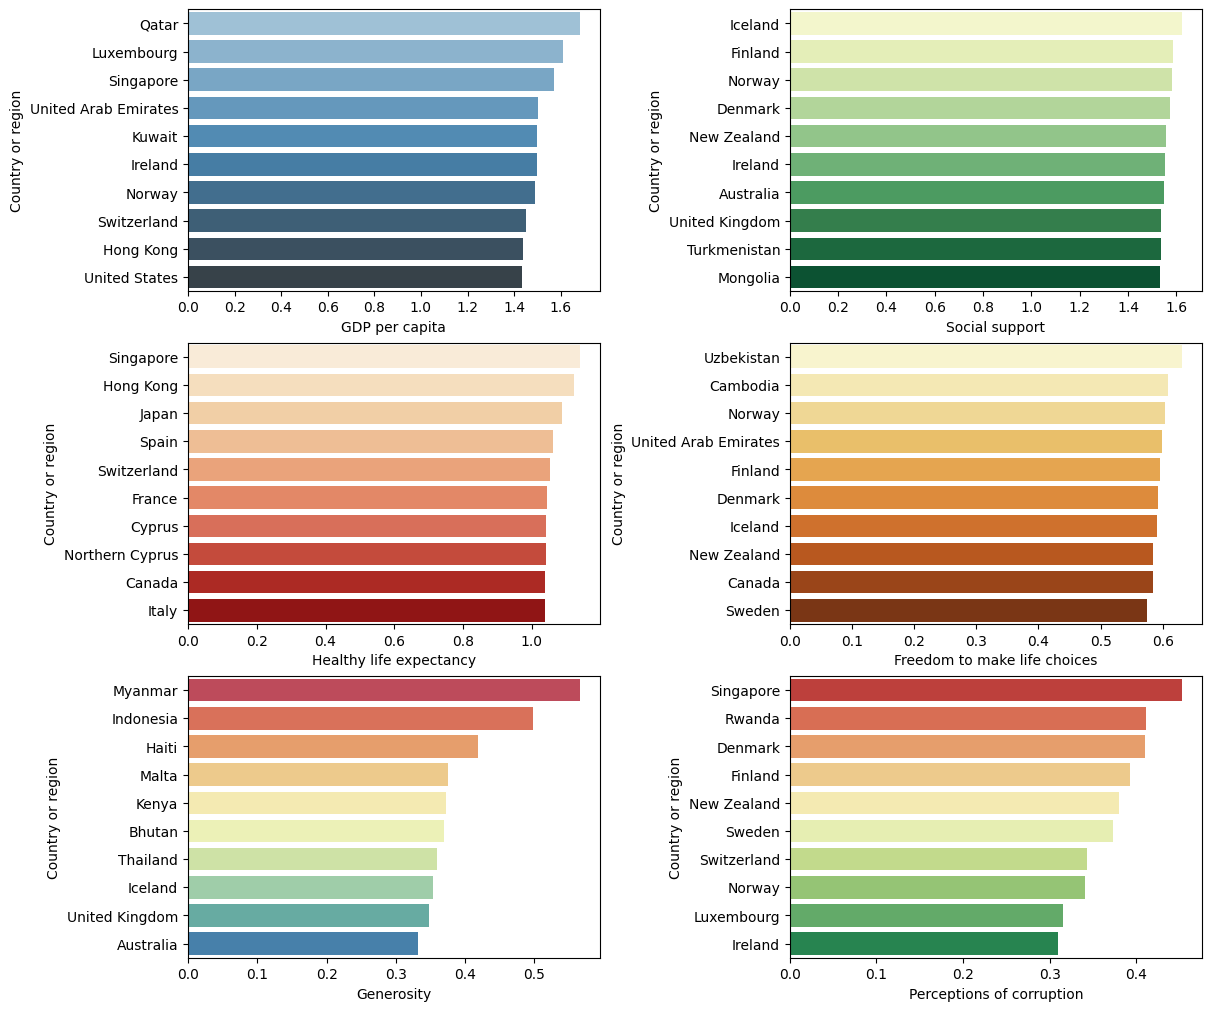

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=2, constrained_layout=True, figsize=(12,10)) 

sns.barplot(x='GDP per capita', y='Country or region', data=df.nlargest(10, 'GDP per capita'), ax=axes[0,0],
            palette='Blues_d')

sns.barplot(x='Social support', y='Country or region', data=df.nlargest(10, 'Social support'), ax=axes[0,1],
            palette='YlGn')

sns.barplot(x='Healthy life expectancy', y='Country or region', data=df.nlargest(10, 'Healthy life expectancy'), ax=axes[1,0],
            palette='OrRd')

sns.barplot(x='Freedom to make life choices', y='Country or region', data=df.nlargest(10, 'Freedom to make life choices'), ax=axes[1,1],
            palette='YlOrBr')

sns.barplot(x='Generosity', y='Country or region', data=df.nlargest(10, 'Generosity'), ax=axes[2,0],
            palette='Spectral')

sns.barplot(x='Perceptions of corruption', y='Country or region', data=df.nlargest(10, 'Perceptions of corruption'), ax=axes[2,1],
            palette='RdYlGn')

Теперь хочу присвоить каждой стране категорию высокого, среднего и низкого уровня в соответствии с их показателями счастья.Таким образом, мы должны определить границу, в которой должны находиться эти категории.

In [10]:
print('max:', df['Score'].max())
print('min:', df['Score'].min())
add = df['Score'].max() - df['Score'].min()
grp = round(add/3.3)
print('range difference:', (grp))

max: 7.769
min: 2.853
range difference: 1


In [11]:
low=df['Score'].min() + grp
mid = low + grp

print('upper bound of low grp', low)
print('upper bound of Mid grp', mid)
print('upper bound of High grp', 'max:', df['Score'].max())

upper bound of low grp 3.853
upper bound of Mid grp 4.853
upper bound of High grp max: 7.769


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Overall rank                  156 non-null    int64  
 1   Country or region             156 non-null    object 
 2   Score                         156 non-null    float64
 3   GDP per capita                156 non-null    float64
 4   Social support                156 non-null    float64
 5   Healthy life expectancy       156 non-null    float64
 6   Freedom to make life choices  156 non-null    float64
 7   Generosity                    156 non-null    float64
 8   Perceptions of corruption     156 non-null    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 11.1+ KB


Наконец, добавляем новую категорию столбцов в набор данных и распределяем уровни High, Low, Mid.

In [13]:
cat = []
for i in df.Score:
  if (i>0 and i<low):
    cat.append('Low')

  elif (i>low and i<mid):
    cat.append('Mid')
  else:
    cat.append('High')

df['Category'] = cat         

Также будем стилизовать набор данных как зеленую зону и красную зону.Если страна относится к высокой категории, то она находится в зеленой зоне, а если она относится к средней или низкой категории, то это будет красная зона

In [14]:
color = (df.Category == 'High').map({True: 'background-color: limegreen', False: 'background-color: red'})
df.style.apply(lambda s: color)

,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Category
0,1,Finland,7.769000,1.340000,1.587000,0.986000,0.596000,0.153000,0.393000,High
1,2,Denmark,7.600000,1.383000,1.573000,0.996000,0.592000,0.252000,0.410000,High
2,3,Norway,7.554000,1.488000,1.582000,1.028000,0.603000,0.271000,0.341000,High
3,4,Iceland,7.494000,1.380000,1.624000,1.026000,0.591000,0.354000,0.118000,High
4,5,Netherlands,7.488000,1.396000,1.522000,0.999000,0.557000,0.322000,0.298000,High
5,6,Switzerland,7.480000,1.452000,1.526000,1.052000,0.572000,0.263000,0.343000,High
6,7,Sweden,7.343000,1.387000,1.487000,1.009000,0.574000,0.267000,0.373000,High
7,8,New Zealand,7.307000,1.303000,1.557000,1.026000,0.585000,0.330000,0.380000,High
8,9,Canada,7.278000,1.365000,1.505000,1.039000,0.584000,0.285000,0.308000,High
9,10,Austria,7.246000,1.376000,1.475000,1.016000,0.532000,0.244000,0.226000,High


Теперь, сравним Россию с другими страннами

In [15]:
df.loc[df['Country or region']=='Russia']

,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Category
67,68,Russia,5.648,1.183,1.452,0.726,0.334,0.082,0.031,High


Хорошая позиция была на 2019 год. Теперь мы проверим Канаду, Великобританию и США

In [16]:
df.loc[df['Country or region']=='United States']

,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Category
18,19,United States,6.892,1.433,1.457,0.874,0.454,0.28,0.128,High


In [17]:
df.loc[df['Country or region']=='United Kingdom']

,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Category
14,15,United Kingdom,7.054,1.333,1.538,0.996,0.45,0.348,0.278,High


In [18]:
df.loc[df['Country or region']=='Canada']

,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Category
8,9,Canada,7.278,1.365,1.505,1.039,0.584,0.285,0.308,High


Таким образом, все они относятся к ВЫСОКОЙ категории, и, по-видимому, Канада находится довольно высоко и имеет отличный показатель счастья.Неудивительно, что люди стекаются в эти страны.

Давайте проведем сравнительный анализ вышеупомянутых четырех стран, чтобы понять, почему у них такой высокий рейтинг по всему миру, и получить некоторое представление

In [19]:
d= df[(df['Country or region'].isin(['Russia','Canada','United Kingdom', 'United States']))]
d

,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Category
8,9,Canada,7.278,1.365,1.505,1.039,0.584,0.285,0.308,High
14,15,United Kingdom,7.054,1.333,1.538,0.996,0.450,0.348,0.278,High
18,19,United States,6.892,1.433,1.457,0.874,0.454,0.280,0.128,High
67,68,Russia,5.648,1.183,1.452,0.726,0.334,0.082,0.031,High


Социальная поддержка в сравнении с ВВП на душу населения и ожидаемой продолжительностью здоровой жизни

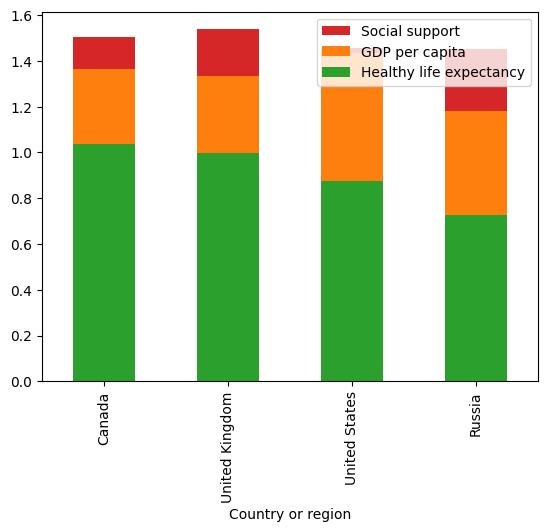

In [20]:
ax = d.plot(y='Social support', x='Country or region', kind='bar', color='C3')

d.plot(y='GDP per capita', x='Country or region', kind='bar', ax=ax, color='C1')
d.plot(y='Healthy life expectancy', x='Country or region', kind='bar', ax=ax, color='C2')

plt.show()

Свобода делать жизненный выбор против щедрости против коррупции

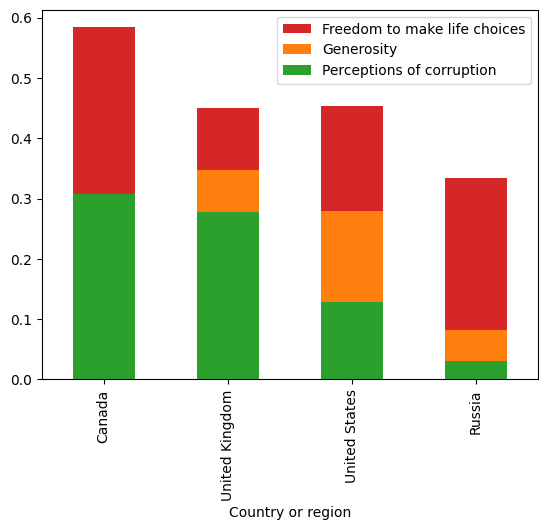

In [21]:
ax = d.plot(y='Freedom to make life choices', x='Country or region', kind='bar', color='C3')

d.plot(y='Generosity', x='Country or region', kind='bar', ax=ax, color='C1')
d.plot(y='Perceptions of corruption', x='Country or region', kind='bar', ax=ax, color='C2')

plt.show()

Географическая визуализация показателя счастья

In [22]:
import plotly.graph_objs as go
from plotly.offline import iplot

data = dict(type = 'choropleth', 
           locations = df['Country or region'],
           locationmode = 'country names',
           colorscale='RdYlGn',
           z = df['Score'], 
           text = df['Country or region'],
           colorbar = {'title':'Happiness Score'})

layout = dict(title = 'Geographical Visualization of Happiness Score', 
              geo = dict(showframe = True, projection = {'type': 'azimuthal equal area'}))

choromap3 = go.Figure(data = [data], layout=layout)
iplot(choromap3)

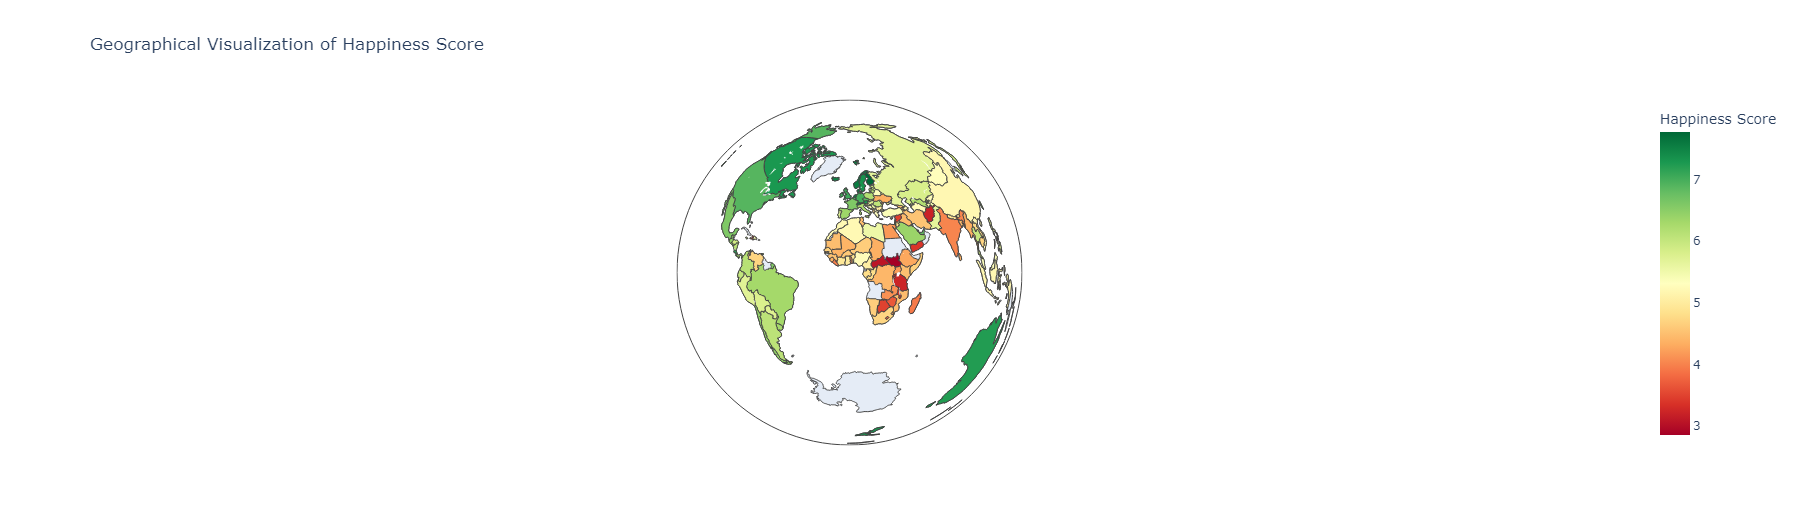

Ознакомьтесь с предыдущими отчетами о счастье, чтобы увидеть изменения в распределении атрибутов

In [23]:
folder = '/content/drive/My Drive/Git/'
filename_15 = '2015.csv'
filename_16 = '2016.csv'
filename_17 = '2017.csv'
filename_18 = '2018.csv'

df15 = pd.read_csv(os.path.join(folder, filename_15))
df16 = pd.read_csv(os.path.join(folder, filename_16))
df17 = pd.read_csv(os.path.join(folder, filename_17))
df18 = pd.read_csv(os.path.join(folder, filename_18))

In [24]:
df15.head(2)

,Country,Region,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,Switzerland,Western Europe,1,7.587,0.03411,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738
1,Iceland,Western Europe,2,7.561,0.04884,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201


In [25]:
df16.head(2)

,Country,Region,Happiness Rank,Happiness Score,Lower Confidence Interval,Upper Confidence Interval,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,Denmark,Western Europe,1,7.526,7.460,7.592,1.44178,1.16374,0.79504,0.57941,0.44453,0.36171,2.73939
1,Switzerland,Western Europe,2,7.509,7.428,7.590,1.52733,1.14524,0.86303,0.58557,0.41203,0.28083,2.69463


In [26]:
df17.head(2)

,Country,Happiness.Rank,Happiness.Score,Whisker.high,Whisker.low,Economy..GDP.per.Capita.,Family,Health..Life.Expectancy.,Freedom,Generosity,Trust..Government.Corruption.,Dystopia.Residual
0,Norway,1,7.537,7.594445,7.479556,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,2.277027
1,Denmark,2,7.522,7.581728,7.462272,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,2.313707


In [27]:
df18.head(2)

,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,1,Finland,7.632,1.305,1.592,0.874,0.681,0.202,0.393
1,2,Norway,7.594,1.456,1.582,0.861,0.686,0.286,0.340


Давайте рассмотрим экономику (денежную), социальную поддержку (семью) и здоровье в качестве основных забот для человека, проживающего в стране, то есть общее благополучие.Давайте посмотрим, как эти распределения меняются с годами или остаются неизменными.

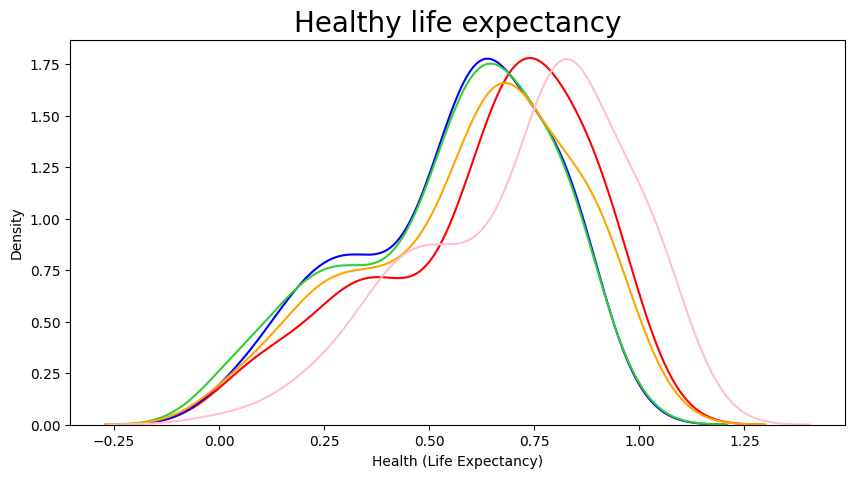

In [28]:
plt.figure(figsize=(10,5))
sns.kdeplot(df15['Health (Life Expectancy)'], color='red')
sns.kdeplot(df16['Health (Life Expectancy)'], color='blue')
sns.kdeplot(df17['Health..Life.Expectancy.'], color='limegreen')
sns.kdeplot(df18['Healthy life expectancy'], color='orange')
sns.kdeplot(df['Healthy life expectancy'], color='pink')
plt.title('Healthy life expectancy', size=20)
plt.show()

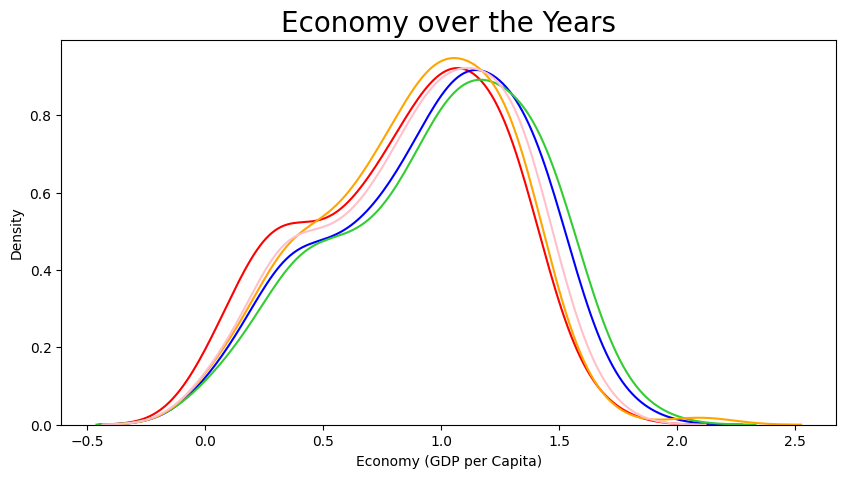

In [29]:
plt.figure(figsize=(10,5))
sns.kdeplot(df15['Economy (GDP per Capita)'],color='red')
sns.kdeplot(df16['Economy (GDP per Capita)'],color='blue')
sns.kdeplot(df17['Economy..GDP.per.Capita.'],color='limegreen')
sns.kdeplot(df18['GDP per capita'],color='orange')
sns.kdeplot(df['GDP per capita'],color='pink')
plt.title('Economy over the Years',size=20)
plt.show()

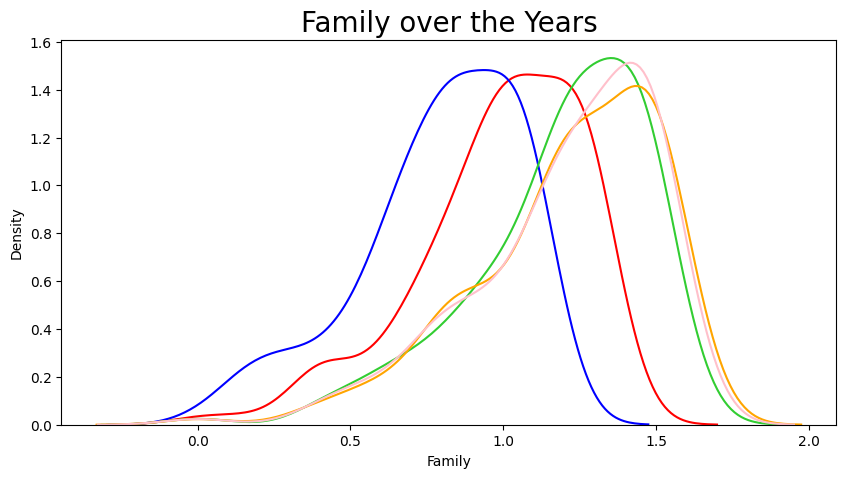

In [30]:
plt.figure(figsize=(10,5))
sns.kdeplot(df15['Family'],color='red')
sns.kdeplot(df16['Family'],color='blue')
sns.kdeplot(df17['Family'],color='limegreen')
sns.kdeplot(df18['Social support'],color='orange')
sns.kdeplot(df['Social support'],color='pink')
plt.title('Family over the Years',size=20)
plt.show()

Следующая на очереди взаимосвязь между свободой и коррупцией, распространенной в правительстве. 

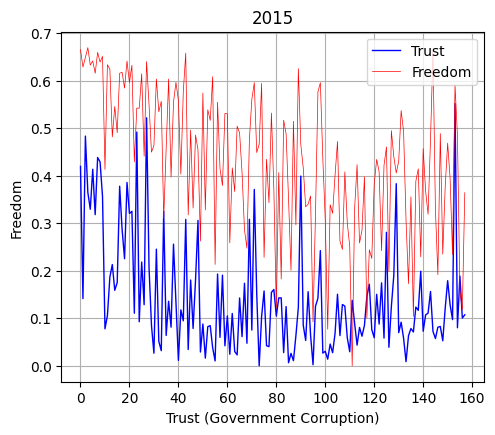

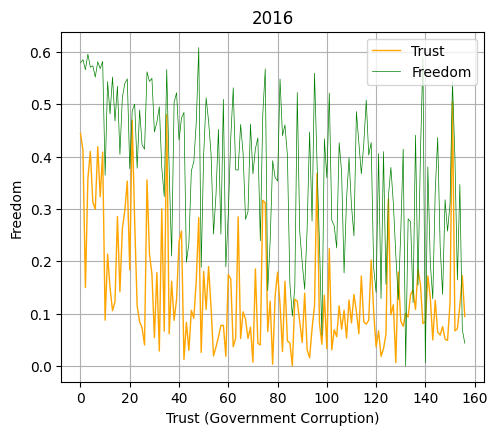

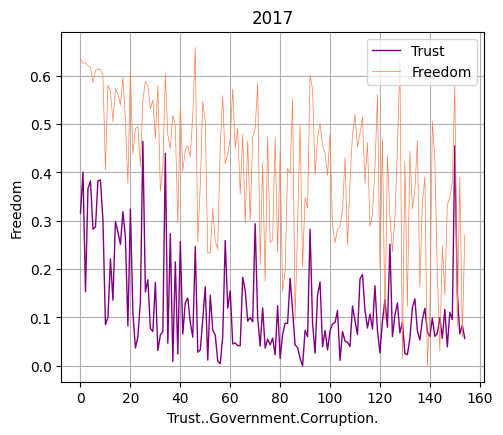

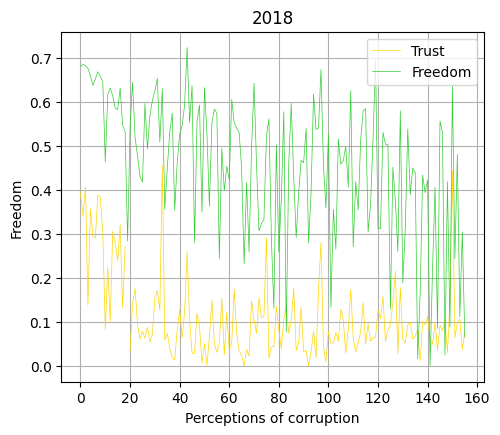

In [31]:
fig = plt.figure(figsize=(12,10))

plt.subplot(2,2,1)
df15['Trust (Government Corruption)'].plot(kind='line', color='blue', label='Trust',
                                           linewidth=1, grid=True, linestyle='-')
df15["Freedom"].plot(kind="line", color="red", label="Freedom", linewidth=0.5,grid=True,linestyle="-")
plt.xlabel('Trust (Government Corruption)')
plt.ylabel("Freedom")
plt.title('2015')
plt.legend(loc='upper right')
plt.show()

fig = plt.figure(figsize=(12,10))
plt.subplot(2, 2, 2)
df16["Trust (Government Corruption)"].plot(kind='line', color='orange',label='Trust',linewidth=1,grid=True,linestyle="-")
df16["Freedom"].plot(kind="line", color="green", label="Freedom", linewidth=0.5,grid=True,linestyle="-")
plt.xlabel('Trust (Government Corruption)')
plt.ylabel('Freedom')
plt.title('2016')
plt.legend(loc='upper right')
plt.show()

fig = plt.figure(figsize=(12,10))
plt.subplot(2, 2, 3)
df17["Trust..Government.Corruption."].plot(kind='line', color='purple',label='Trust',linewidth=1,grid=True,linestyle="-")
df17["Freedom"].plot(kind="line", color="coral", label="Freedom", linewidth=0.5,grid=True,linestyle="-")
plt.xlabel('Trust..Government.Corruption.')
plt.ylabel('Freedom')
plt.title('2017')
plt.legend(loc='upper right')
plt.show()

fig = plt.figure(figsize=(12,10))
plt.subplot(2, 2, 4)
df18["Perceptions of corruption"].plot(kind='line', color='gold',label='Trust',linewidth=0.5,grid=True,linestyle="-")
df18["Freedom to make life choices"].plot(kind="line", color="limegreen", label="Freedom", linewidth=0.5,grid=True,linestyle="-")
plt.xlabel('Perceptions of corruption')
plt.ylabel('Freedom')
plt.title('2018')
plt.legend(loc='upper right')
plt.show()



Добавление нового атрибута Year

In [32]:
df18["Year"] = '2018'
df["Year"] = '2019'
df17["Year"] = '2017'
df16["Year"] = '2016'
df15["Year"] = '2015'

Добавление нескольких фреймов данных для извлечения дополнительной информации. Таким образом, мы выберем некоторые атрибуты из набора, а также изменим имена их столбцов и сделаем их похожими, чтобы упростить добавление части

In [33]:
df.rename(columns={'Country or region': 'Country'}, inplace=True)
data1 = df.filter(['Country', 'GDP per capita', 'Year'], axis=1)

df15.rename(columns={'Economy (GDP per Capita)':'GDP per capita'},inplace=True)
data2=df15.filter(['Country','GDP per capita',"Year"],axis=1)

df16.rename(columns={'Economy (GDP per Capita)':'GDP per capita'},inplace=True)
data3=df16.filter(['Country','GDP per capita',"Year"],axis=1)

df17.rename(columns={'Economy..GDP.per.Capita.':'GDP per capita'},inplace=True)
data4=df17.filter(['Country','GDP per capita','Year'],axis=1)

df18.rename(columns={'Country or region':'Country'},inplace=True)
data5=df18.filter(['Country','GDP per capita',"Year"],axis=1)

data2=data2.append([data3,data4,data5,data1])
data2

<ipython-input-33-86a81dcf0f99>:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,Country,GDP per capita,Year
0,Switzerland,1.39651,2015
1,Iceland,1.30232,2015
2,Denmark,1.32548,2015
3,Norway,1.45900,2015
4,Canada,1.32629,2015
...,...,...,...
151,Rwanda,0.35900,2019
152,Tanzania,0.47600,2019
153,Afghanistan,0.35000,2019
154,Central African Republic,0.02600,2019


У нас есть новая база данных с информацией о ВВП на душу населения в каждой стране за 2015-2019 годы

Смотрим ВВП на душу населения России, США, Великобритании, КАНАДЫ, ФИНЛЯНДИИ за 2015-19 годы

Text(0.5, 1.0, 'GDP per capita 2015-2019')

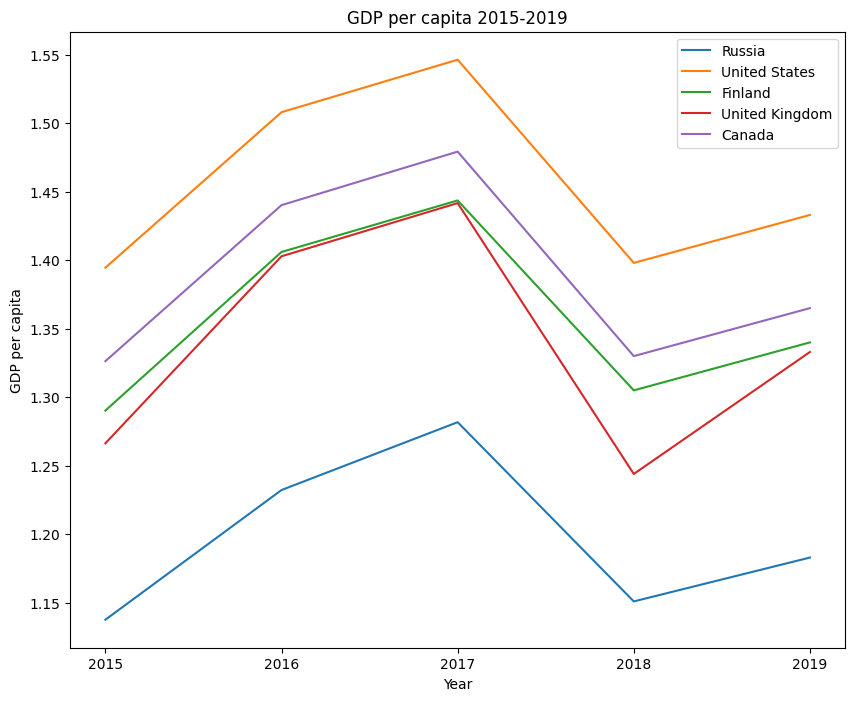

In [34]:
plt.figure(figsize=(10,8))
df=data2[data2["Country"]=='Russia']
sns.lineplot(x='Year', y='GDP per capita', data=df, label='Russia')

df=data2[data2["Country"]=='United States']
sns.lineplot(x='Year', y='GDP per capita', data=df, label='United States')

df=data2[data2["Country"]=='Finland']
sns.lineplot(x='Year', y='GDP per capita', data=df, label='Finland')

df=data2[data2["Country"]=='United Kingdom']
sns.lineplot(x='Year', y='GDP per capita', data=df, label='United Kingdom')

df=data2[data2["Country"]=='Canada']
sns.lineplot(x='Year', y='GDP per capita', data=df, label='Canada')

plt.title('GDP per capita 2015-2019')

Из этого графика мы можем наблюдать следующее:-

- Экономика России достигла своего пика в 2017 году, упала в 2018 году и восстанавливалась в 2019 году

- В США самая высокая экономика

- Экономика Великобритании в 2018 году значительно снизилась

- В 2016-2017 годах у Финляндии и Великобритании были схожие экономические показатели

Тепловая карта для первых 10 стран (в алфавитном порядке) и их ВВП на душу населения за разные годы

<Axes: xlabel='Year', ylabel='Country'>

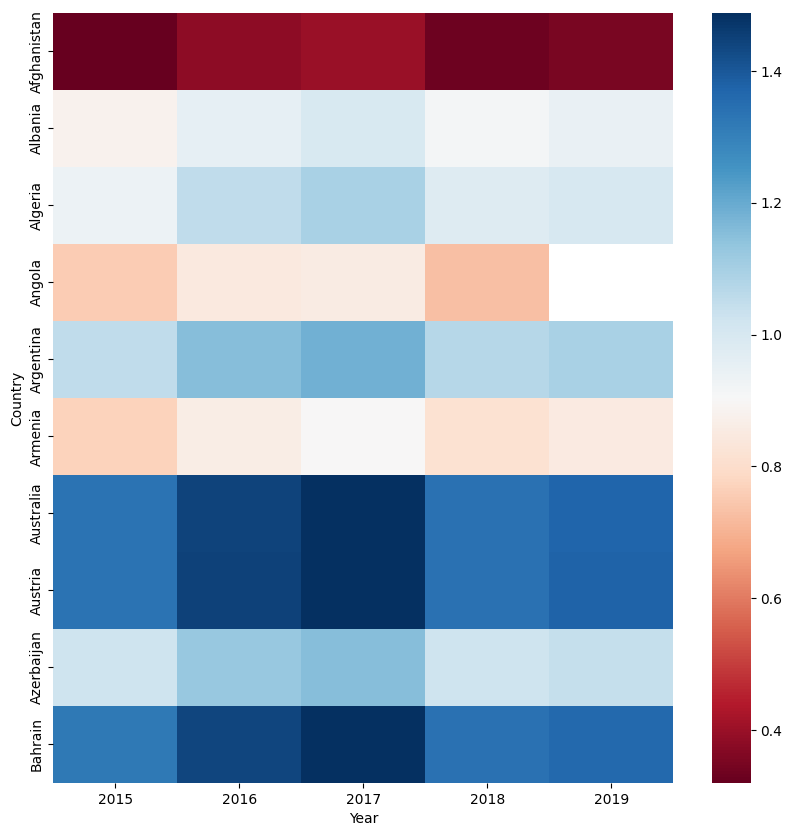

In [35]:
plt.figure(figsize=(10, 10))
h=pd.pivot_table(data2,values='GDP per capita', index=['Country'], columns='Year')
h=h.head(10)
sns.heatmap(h,cmap="RdBu")

# **HIERARCHICAL CLUSTERING (с 2019 года)**

Иерархическая кластеризация, также известная как иерархический кластерный анализ, представляет собой алгоритм, который группирует похожие объекты в группы, называемые кластерами. Конечная точка - это набор кластеров, где каждый кластер отличается друг от друга, а объекты внутри каждого кластера в целом похожи друг на друга

В данном случае существует множество атрибутов или практик, от которых зависит показатель счастья – ВВП, семья, здоровье, коррупция и т.д. Наша цель состоит в том, чтобы на основе этих данных создать кластеры, которые смогут объединить похожие страны. Для решения этой задачи мы будем использовать иерархическую кластеризацию.

In [39]:
original = original.drop(['Country or region','Overall rank'],axis=1)

Но прежде чем применять иерархическую кластеризацию, мы должны нормализовать данные таким образом, чтобы масштаб каждой переменной был одинаковым. Почему это так важно? Что ж, если масштаб переменных не одинаков, модель может быть смещена в сторону переменных с более высокой величиной

In [42]:
from sklearn.preprocessing import normalize

data_scaled = normalize(original)
data_scaled = pd.DataFrame(data_scaled, columns = original.columns)

datasc = data_scaled.copy()
data_scaled.head()

,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,0.955020,0.164722,0.195085,0.121206,0.073264,0.018808,0.048310
1,0.952077,0.173253,0.197055,0.124772,0.074162,0.031569,0.051362
2,0.948783,0.186893,0.198699,0.129117,0.075737,0.034038,0.042830
3,0.949879,0.174918,0.205845,0.130048,0.074910,0.044870,0.014957
4,0.952236,0.177527,0.193550,0.127041,0.070833,0.040948,0.037896


Давайте нарисуем дендрограмму (Дендрограмма - это древовидная диаграмма, которая записывает последовательности слияний или расщеплений), чтобы помочь нам определить количество кластеров для задачи

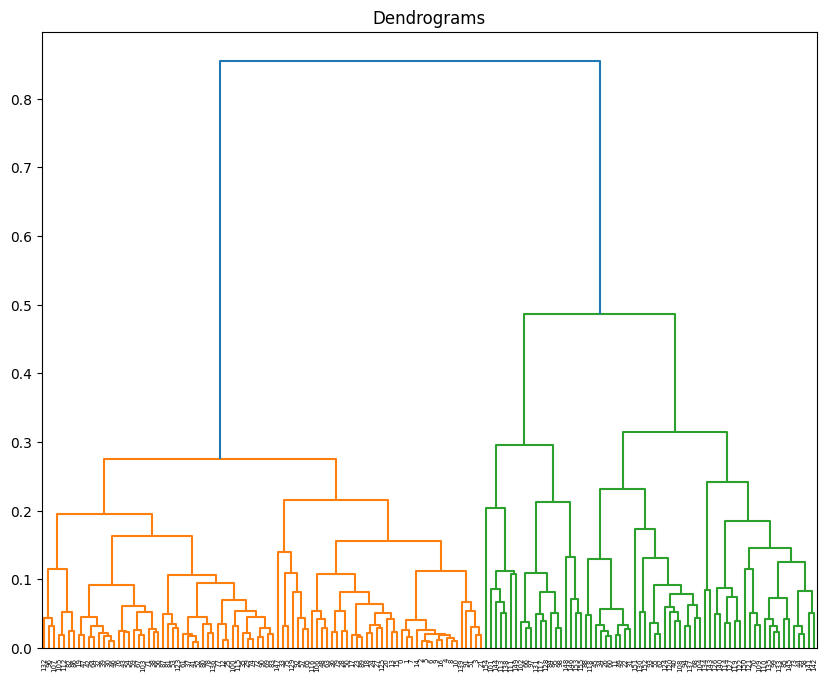

In [44]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10,8))
plt.title('Dendrograms')
dend = shc.dendrogram(shc.linkage(data_scaled, method='ward'))

Ось x содержит выборки, а ось y представляет расстояние между этими выборками.

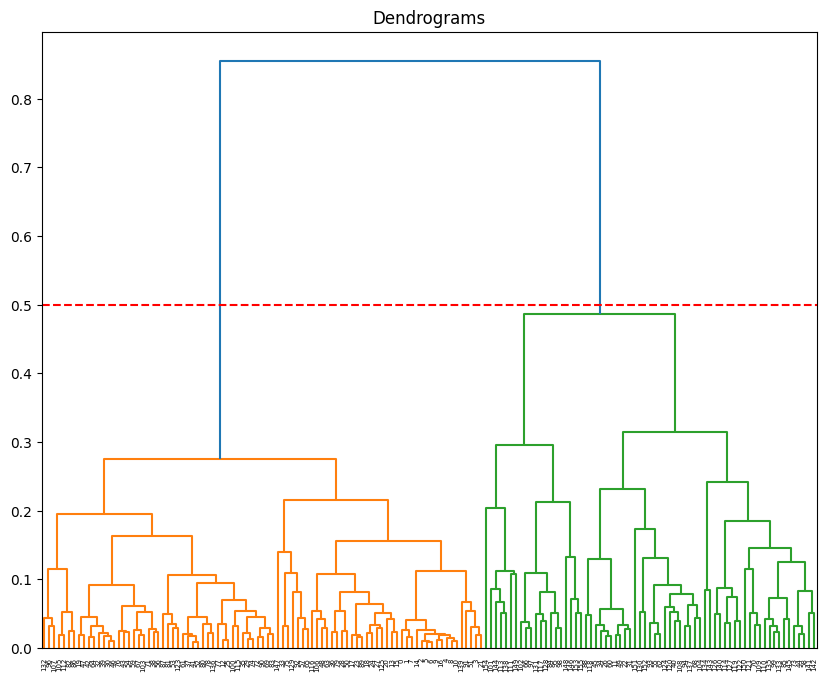

In [45]:
plt.figure(figsize=(10,8))
plt.title('Dendrograms')
dend = shc.dendrogram(shc.linkage(data_scaled, method='ward'))
plt.axhline(y=0.5, color='r', linestyle='--')

У нас есть два кластера, поскольку эта линия пересекает дендрограмму в двух точках. Давайте теперь применим иерархическую кластеризацию для 2 кластеров

In [46]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
cluster.fit_predict(data_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning:

Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead



array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0])

- 0 - принадлежит к кластеру номер 1

- 1 - принадлежит к кластеру номер 2

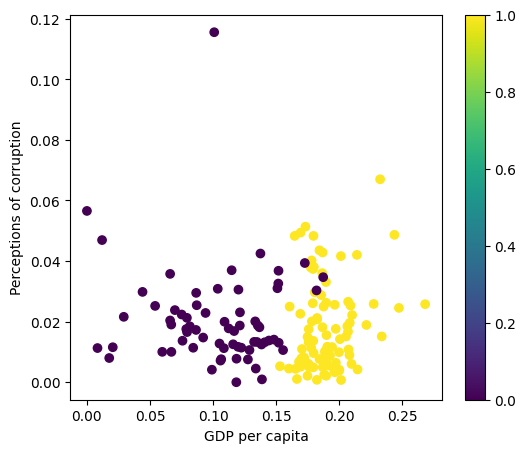

In [48]:
plt.figure(figsize=(6,5))
plt.scatter(data_scaled['GDP per capita'], data_scaled['Perceptions of corruption'], c=cluster.labels_)
plt.xlabel('GDP per capita')
plt.ylabel('Perceptions of corruption')
plt.colorbar()

Итак, здесь мы можем ясно видеть два четко очерченных кластера

# **K MEANS CLUSTERING**

k-means - это один из простейших алгоритмов обучения без контроля, который решает хорошо известную проблему кластеризации. Процедура основана на простом и доступном способе классификации заданного набора данных по определенному числу кластеров (предположим, k кластеров), фиксированному априори. Основная идея состоит в том, чтобы определить k центров, по одному для каждого кластера.

Давайте выберем эти две переменные и визуализируем точки данных

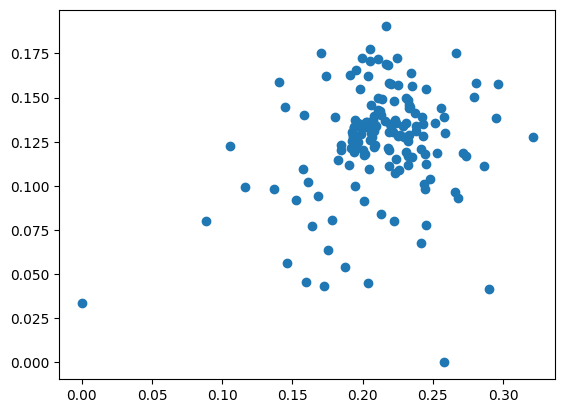

In [50]:
X = datasc[['Social support', 'Healthy life expectancy']]
plt.scatter(X['Social support'], X['Healthy life expectancy'])
plt.show()

Теперь при выполнении K MEANS CLUSTERING с 3 кластерами

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



[[0.2054251  0.13849264]
 [0.1455177  0.07640553]
 [0.25122217 0.11686624]]


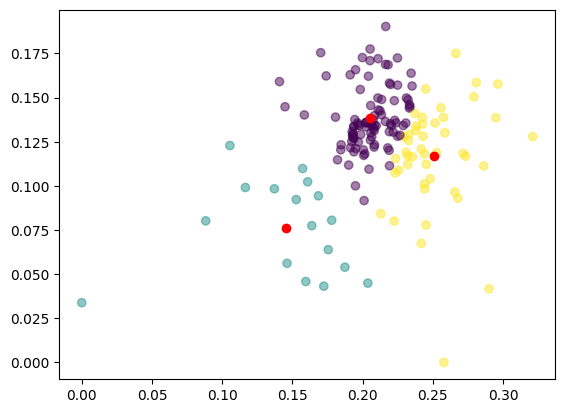

In [63]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3).fit(X)
centroids = kmeans.cluster_centers_
print(centroids)

plt.scatter(X['Social support'], X['Healthy life expectancy'], c=kmeans.labels_.astype(float), alpha=0.5)
plt.scatter(centroids[:,0], centroids[:,1], c='r')
plt.show()

Итак, здесь мы можем ясно видеть три четко очерченных скопления с их центроидами